# Домашнее задание  
## по теме «Классификация SVM»

 Столбец “smoking” является целевой переменной

Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from eda_tools import get_all_outliers, get_boxplot, get_eda, get_cat_eda, get_correlation_target # Тут мои функции что бы кода меньше было в блокноте

In [2]:
# Загрузка файла с данными из архива
archive_path = 'input_data/smoking_data.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train_dataset.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных

In [3]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод "шапки"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

### EDA - анализ

In [5]:
eda_df = get_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
age,0,0.0,85.0,20.0,44.127591,40.0,145.529573,30.0,60.0,40.0,55.0,0,int64,14,0,0,211
height_cm,0,0.0,190.0,130.0,164.689488,165.0,84.410288,150.0,175.0,160.0,170.0,0,int64,13,0,152,25
weight_kg,0,0.0,135.0,30.0,65.938718,65.0,166.321797,50.0,85.0,55.0,75.0,0,int64,22,0,0,146
waist_cm,0,0.0,129.0,51.0,82.062115,82.0,86.989160,70.0,94.0,76.0,88.0,10693,float64,545,0,24,353
eyesight_left,0,0.0,9.9,0.1,1.014955,1.0,0.248529,0.6,1.5,0.8,1.2,30083,float64,19,0,563,358
eyesight_right,0,0.0,9.9,0.1,1.008768,1.0,0.243851,0.6,1.5,0.8,1.2,29993,float64,17,0,621,329
hearing_left,0,0.0,2.0,1.0,1.025369,1.0,0.024726,1.0,1.0,1.0,1.0,0,int64,2,0,0,989
hearing_right,0,0.0,2.0,1.0,1.026190,1.0,0.025505,1.0,1.0,1.0,1.0,0,int64,2,0,0,1021
systolic,0,0.0,233.0,71.0,121.475631,120.0,186.145675,104.0,138.0,112.0,130.0,0,int64,125,0,26,439


Выводы:
- пропусков нет уже радует;
- все данные можно отнести к числовым;
- есть выбросы, нужно смотреть дополнительно;
- большой разброс масштабов;
- доля 1 в целевой переменной: 36,7278% есть предположение, что класс 0 будет лудше классифицироваться чем класс 1

### Матрица корреляции

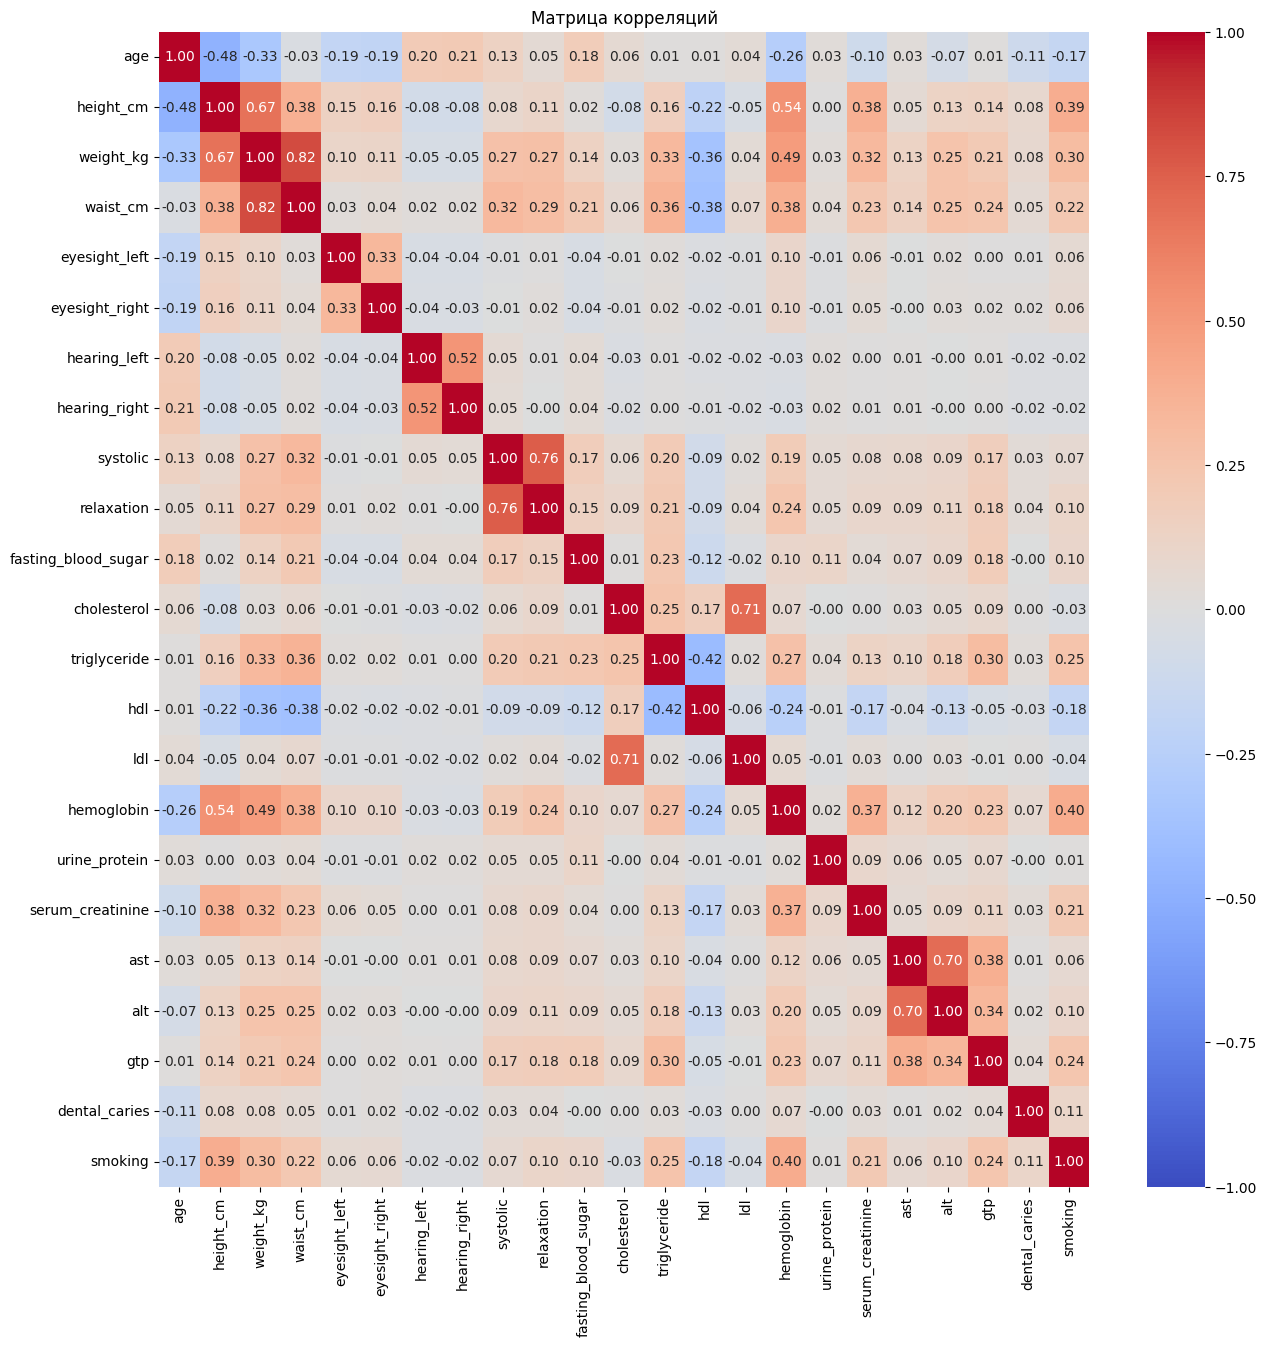

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

In [7]:
# plt.figure(figsize=(15, 15))
# sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
# plt.show()

Выводы:
- ура красивая цветная диаграмма!!!
- практически все данные имеют зависимости. Некоторые весьма ощутимо между собой, что может привести к переобучению.
- для модели использую все столбцы

### Box-plot

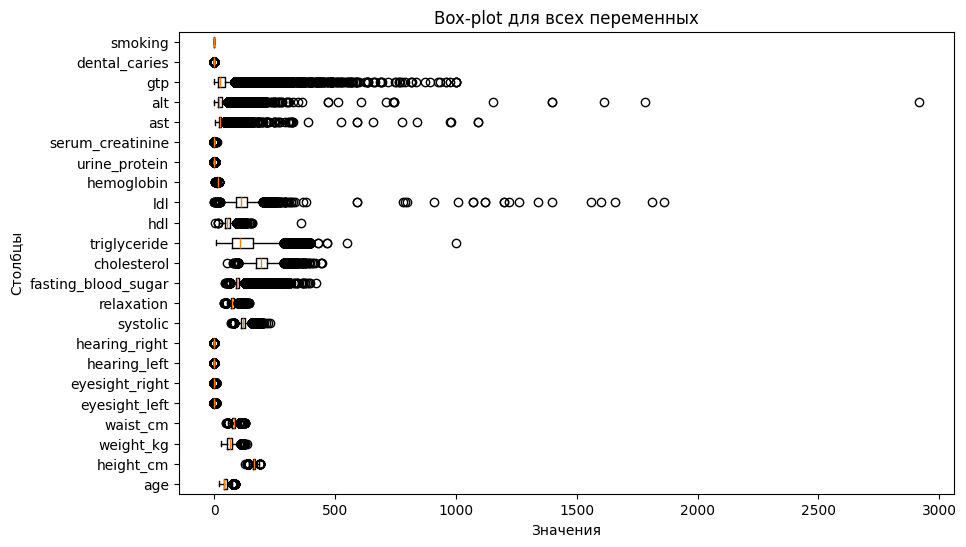

In [8]:
get_boxplot(df,'Box-plot для всех переменных').show()

Вывод:
- не мешало бы обработать выбросы, но учитывая что я не владею предметной областью, и считая что выбросы возможны например при длительном курении, оставлю как есть. 
- Для масштабирования применю RobustScaler, судя по опиманием он более устойчив к выбросам.

In [9]:
# Разделение параметров
X = df.drop(columns=['smoking'])
y = df['smoking']                

In [10]:
# Масштабирование данных (кроме целевого столбца)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели SVM
model = SVC(kernel='rbf', C=1.0737555188414591, gamma='scale')

# Обучение модели
model.fit(X_train, y_train)

SVC(C=1.0737555188414591)

In [12]:
# Предсказание на тестовых данных
y_pred = model.predict(X_test)

In [13]:
# Оценка модели
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Для многоклассовой классификации
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод метрик
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Подробный отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[4028  947]
 [ 944 1878]]
Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1 Score: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4975
           1       0.66      0.67      0.67      2822

    accuracy                           0.76      7797
   macro avg       0.74      0.74      0.74      7797
weighted avg       0.76      0.76      0.76      7797



### Выводы по модели:
- a) Чему равен гиперпараметр C? Почему вы выбрали именно такой C? 
    - C = 1.0737555188414591
    - Гиперпараметры подбирал RandomizedSearchCV Лучшие параметры: {'svm__C': np.float64(1.0737555188414591), 'svm__gamma': np.float64(0.24277134043030424), 'svm__kernel': 'rbf'}
    Accuracy на тестовых данных: 0.7648768809849521
- b) Какое ядро вы выбрали для алгоритма? 
    - "rbf", подобран RandomizedSearchCV
- с) Насколько ваш алгоритм верно предсказывает целевую переменную?
    - Согласно метрикам модель правильно классифицирует 76% всех объектов, что не является идеальным результатом, но учитывая что небыло обработки выбросов нормально. 
    - Для класса 0 точность 81%, для класса 1 точность 67%. 